## Try phase association for stations for 2012
Refernce: https://github.com/yetinam/pyocto

In [1]:
# !pip3 install numpy
# !pip3 install pyrocko

In [1]:
import pyocto
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
from scipy import signal
from obspy.signal.trigger import classic_sta_lta
import pygmt

from obspy.clients.fdsn import Client
from obspy.core.utcdatetime import UTCDateTime
from pnwstore.mseed import WaveformClient


In [2]:
# Import the velocity model from https://colab.research.google.com/github/yetinam/pyocto/blob/main/examples/02_velocity_models.ipynb#scrollTo=1c52ed9e-d9c1-4fa6-a549-de702bc9d439
# !wget https://github.com/yetinam/pyocto/raw/main/tests/data/graeber.csv

## Input Data

In [5]:
picks = pd.read_csv("../data/datasets_nwa_shore/picks_nwa_shore.csv",index_col=0)
stations = pd.read_csv("../data/datasets_nwa_shore/all_stations_nwa_shore.csv",index_col=0)

In [6]:
picks

,station,phase,time,pick_id
0,OZB,P,2011-01-01T09:37:24.350000Z,305
1,OZB,P,2011-01-01T20:50:40.675000Z,306
2,FORK,P,2011-01-01T14:45:23.465000Z,3240
3,FORK,P,2011-01-01T14:43:06.940000Z,3241
4,FORK,P,2011-01-01T14:46:10.740000Z,3242
...,...,...,...,...
956482,FORK,S,2015-12-31T15:58:55.590000Z,23571068
956483,FORK,S,2015-12-31T18:33:30.515000Z,23571069
956484,FORK,S,2015-12-31T18:35:30.465000Z,23571070
956485,FORK,S,2015-12-31T21:03:58.340000Z,23571071


In [7]:
stations

,id,longitude,latitude,elevation
0,OZB,-125.497800,48.961200,626.0
1,FORK,-124.566200,47.947500,44.9
2,OFR,-124.396042,47.933128,152.0
3,BMSB,-125.135500,48.835600,10.0
4,J65A,-125.139603,47.891300,-165.2
5,J73A,-126.192497,48.767700,-143.3
6,M01A,-126.722099,49.150398,-132.9
7,NTKA,-126.616600,49.592400,12.0
8,J65C,-125.139801,47.891300,-169.0
9,J73C,-126.192596,48.767899,-133.0


## Create a 1D velocity model
Not needed for now.

In [8]:
# !wget https://github.com/yetinam/pyocto/raw/main/tests/data/graeber.csv

In [9]:
layers = pd.read_csv("../data/nwa_shore.csv")

# Strip leading/trailing spaces from column names
layers.columns = layers.columns.str.strip()
layers

,depth,vp,vp_grad,vs,vs_grad,x,y
0,0.0,1.9,0.384615,1.096966,0.222058,1,0.0
1,1.3,2.4,0.478261,1.385641,0.276124,1,0.0
2,5.9,4.6,0.160000,2.655811,0.092376,1,0.0
3,8.4,5.0,0.312500,2.886751,0.180422,1,0.0
4,11.6,6.0,0.307692,3.464102,0.177646,1,0.0
5,12.9,6.4,0.312500,3.695042,0.180422,1,0.0
6,14.5,6.9,0.062500,3.983717,0.036084,1,0.0
7,16.1,7.0,0.625000,4.041452,0.360844,1,0.0
8,17.7,8.0,0.625000,4.618802,0.360844,1,NaN


In [10]:
model_path = "velocity_model"
pyocto.VelocityModel1D.create_model(layers, 1., 400, 250, model_path)

In [11]:
velocity_model_1d = pyocto.VelocityModel1D(model_path, tolerance=2.0)

## The OctoAssociator class

In [12]:
#  Define the associator parameters
associator = pyocto.OctoAssociator.from_area(
    lat=(38, 51),
    lon=(-132, -119),
    zlim=(0, 50),
    time_before=300,
    velocity_model=velocity_model_1d,
    n_picks=5,
    n_p_picks=1,
    n_s_picks=3,
    n_p_and_s_picks=1,
)

In [13]:
associator.transform_stations(stations)
stations

,id,longitude,latitude,elevation,x,y,z
0,OZB,-125.497800,48.961200,626.0,0.161103,495.931779,-0.6260
1,FORK,-124.566200,47.947500,44.9,69.755514,383.631296,-0.0449
2,OFR,-124.396042,47.933128,152.0,82.489151,382.201170,-0.1520
3,BMSB,-125.135500,48.835600,10.0,26.758765,482.028159,-0.0100
4,J65A,-125.139603,47.891300,-165.2,26.951184,377.023274,0.1652
5,J73A,-126.192497,48.767700,-143.3,-50.906316,474.644562,0.1433
6,M01A,-126.722099,49.150398,-132.9,-89.152651,517.691903,0.1329
7,NTKA,-126.616600,49.592400,12.0,-80.729452,566.729771,-0.0120
8,J65C,-125.139801,47.891300,-169.0,26.936378,377.023205,0.1690
9,J73C,-126.192596,48.767899,-133.0,-50.913392,474.666758,0.1330


## Convert the timestamps to floats

In [14]:
# Convert the times to timestamps
picks["time"] = picks["time"].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%dT%H:%M:%S.%fZ'))
picks["time"] = picks["time"].apply(lambda x: x.timestamp())
picks

,station,phase,time,pick_id
0,OZB,P,1.293875e+09,305
1,OZB,P,1.293915e+09,306
2,FORK,P,1.293893e+09,3240
3,FORK,P,1.293893e+09,3241
4,FORK,P,1.293893e+09,3242
...,...,...,...,...
956482,FORK,S,1.451578e+09,23571068
956483,FORK,S,1.451587e+09,23571069
956484,FORK,S,1.451587e+09,23571070
956485,FORK,S,1.451596e+09,23571071


In [26]:
# picks['time'] = picks['time'].apply(lambda x: (datetime.datetime.strptime(x,'%Y-%m-%dT%H:%M:%S.%fZ')).timestamp())
# picks

## Apply  the associator

In [15]:
# Association 
events, assignments = associator.associate(picks, stations)

In [16]:
# Count how many picks each event has
Counter(events['picks'])

Counter({6: 202, 5: 173, 7: 54, 8: 38, 9: 14, 10: 6, 11: 2, 12: 1})

In [17]:
# Convert the event times and the x, y, and z coordinate to latitudes, longitudes, and depths, respectively
associator.transform_events(events)
events["time"] = events["time"].apply(datetime.datetime.fromtimestamp, tz=datetime.timezone.utc)

In [18]:
events

,idx,time,x,y,z,picks,latitude,longitude,depth
0,0,2011-01-29 19:12:43.481602+00:00,88.693538,324.456120,48.828125,5,47.413045,-124.324744,48.828125
1,1,2011-03-01 17:07:07.540138+00:00,59.686846,375.950591,31.640625,6,47.879445,-124.702035,31.640625
2,2,2011-03-20 04:20:39.627115+00:00,-142.244353,664.891786,49.609375,6,50.463057,-127.503384,49.609375
3,3,2011-03-21 16:57:21.730601+00:00,170.135403,354.494561,49.609375,6,47.666876,-123.234630,49.609375
4,4,2011-04-23 20:03:08.498333+00:00,61.918130,375.950591,32.421875,6,47.879234,-124.672207,32.421875
...,...,...,...,...,...,...,...,...,...
485,485,2015-12-10 11:49:32.628968+00:00,-11.714241,493.243551,23.828125,6,48.936916,-125.659891,23.828125
486,486,2015-12-13 01:35:34.220311+00:00,-19.523735,513.269179,32.421875,6,49.116787,-125.767447,32.421875
487,487,2015-12-15 03:22:53.205921+00:00,67.496340,375.950591,23.828125,6,47.878672,-124.597641,23.828125
488,488,2015-12-17 23:24:16.035731+00:00,192.448242,404.558630,12.890625,5,48.110438,-122.915527,12.890625


In [19]:
#  Save events that have at least 6 picks
events = events.loc[(events['picks'] >= 6)]
events.to_csv('../data/datasets_nwa_shore/events_nwa_shore.csv')


In [32]:
# events.to_csv('~/notebooks/src/association_events.csv')

In [21]:
# Print the assignments

assignments

,event_idx,pick_idx,residual,station,phase,time,pick_id
0,0,3486,0.113323,FORK,P,1.296328e+09,124884
1,0,561724,0.110618,FORK,S,1.296328e+09,124878
2,0,3398,-0.126576,OFR,P,1.296328e+09,123881
3,0,561629,-0.080810,OFR,S,1.296328e+09,123854
4,0,561610,-0.016555,OZB,S,1.296328e+09,121673
...,...,...,...,...,...,...,...
2974,489,956219,0.193057,BFSB,S,1.451461e+09,23567484
2975,489,558421,0.234987,FORK,P,1.451461e+09,23568749
2976,489,956292,-0.141743,FORK,S,1.451461e+09,23568743
2977,489,558390,-0.184442,TOFB,P,1.451461e+09,23567934


In [22]:
# Assign the event information to each pick by using pd.merge
all_pick_assignments = pd.merge(events, assignments, left_on="idx", right_on="event_idx", suffixes=("", "_pick"))
all_pick_assignments

,idx,time,x,y,z,picks,latitude,longitude,depth,event_idx,pick_idx,residual,station,phase,time_pick,pick_id
0,1,2011-03-01 17:07:07.540138+00:00,59.686846,375.950591,31.640625,6,47.879445,-124.702035,31.640625,1,6792,0.302324,FORK,P,1.298999e+09,264471
1,1,2011-03-01 17:07:07.540138+00:00,59.686846,375.950591,31.640625,6,47.879445,-124.702035,31.640625,1,565136,0.095024,FORK,S,1.298999e+09,264468
2,1,2011-03-01 17:07:07.540138+00:00,59.686846,375.950591,31.640625,6,47.879445,-124.702035,31.640625,1,6775,-0.104036,OFR,P,1.298999e+09,263491
3,1,2011-03-01 17:07:07.540138+00:00,59.686846,375.950591,31.640625,6,47.879445,-124.702035,31.640625,1,565080,-0.195118,OFR,S,1.298999e+09,263531
4,1,2011-03-01 17:07:07.540138+00:00,59.686846,375.950591,31.640625,6,47.879445,-124.702035,31.640625,1,6696,0.293664,OZB,P,1.298999e+09,261084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2109,489,2015-12-30 07:39:28.170022+00:00,175.713613,467.496316,15.234375,6,48.680781,-123.113740,15.234375,489,956219,0.193057,BFSB,S,1.451461e+09,23567484
2110,489,2015-12-30 07:39:28.170022+00:00,175.713613,467.496316,15.234375,6,48.680781,-123.113740,15.234375,489,558421,0.234987,FORK,P,1.451461e+09,23568749
2111,489,2015-12-30 07:39:28.170022+00:00,175.713613,467.496316,15.234375,6,48.680781,-123.113740,15.234375,489,956292,-0.141743,FORK,S,1.451461e+09,23568743
2112,489,2015-12-30 07:39:28.170022+00:00,175.713613,467.496316,15.234375,6,48.680781,-123.113740,15.234375,489,558390,-0.184442,TOFB,P,1.451461e+09,23567934


In [23]:
all_pick_assignments[0:10]

,idx,time,x,y,z,picks,latitude,longitude,depth,event_idx,pick_idx,residual,station,phase,time_pick,pick_id
0,1,2011-03-01 17:07:07.540138+00:00,59.686846,375.950591,31.640625,6,47.879445,-124.702035,31.640625,1,6792,0.302324,FORK,P,1.298999e+09,264471
1,1,2011-03-01 17:07:07.540138+00:00,59.686846,375.950591,31.640625,6,47.879445,-124.702035,31.640625,1,565136,0.095024,FORK,S,1.298999e+09,264468
2,1,2011-03-01 17:07:07.540138+00:00,59.686846,375.950591,31.640625,6,47.879445,-124.702035,31.640625,1,6775,-0.104036,OFR,P,1.298999e+09,263491
3,1,2011-03-01 17:07:07.540138+00:00,59.686846,375.950591,31.640625,6,47.879445,-124.702035,31.640625,1,565080,-0.195118,OFR,S,1.298999e+09,263531
4,1,2011-03-01 17:07:07.540138+00:00,59.686846,375.950591,31.640625,6,47.879445,-124.702035,31.640625,1,6696,0.293664,OZB,P,1.298999e+09,261084
5,1,2011-03-01 17:07:07.540138+00:00,59.686846,375.950591,31.640625,6,47.879445,-124.702035,31.640625,1,565030,-0.391857,OZB,S,1.298999e+09,261165
6,2,2011-03-20 04:20:39.627115+00:00,-142.244353,664.891786,49.609375,6,50.463057,-127.503384,49.609375,2,8721,0.839141,FORK,P,1.300595e+09,344264
7,2,2011-03-20 04:20:39.627115+00:00,-142.244353,664.891786,49.609375,6,50.463057,-127.503384,49.609375,2,567101,-1.077741,FORK,S,1.300595e+09,344266
8,2,2011-03-20 04:20:39.627115+00:00,-142.244353,664.891786,49.609375,6,50.463057,-127.503384,49.609375,2,8665,-0.077135,OFR,P,1.300595e+09,343604
9,2,2011-03-20 04:20:39.627115+00:00,-142.244353,664.891786,49.609375,6,50.463057,-127.503384,49.609375,2,567048,0.194016,OFR,S,1.300595e+09,343651


In [24]:
# Save the assignments to a CSV file
all_pick_assignments.to_csv("../data/datasets_nwa_shore/all_pick_assignments_nwa_shore_all.csv")

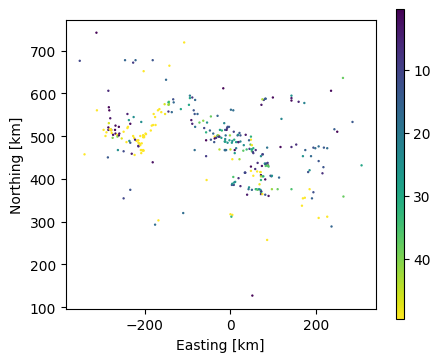

In [25]:
# The parameters in the associator class: n_picks=2,n_p_picks=1,n_s_picks=1,n_p_and_s_picks=1
fig = plt.figure(figsize=(4, 8))
ax = fig.add_subplot()
ax.set_aspect("equal")

# ax.scatter(events["x"], events["y"], c=events["z"])
ax.set_xlabel("Easting [km]")
ax.set_ylabel("Northing [km]")
cax = fig.add_axes([ax.get_position().x1+0.05,ax.get_position().y0,0.02,ax.get_position().height])
cb1 = fig.colorbar(ax.scatter(events["x"], events["y"], c=events["z"],s=0.5,cmap='viridis'), cax=cax)
cb1.ax.invert_yaxis()

## Plot the associated events (not necessary to run cells below)

In [ ]:
# Read the event dataframe saved above
events = pd.read_csv('../data/events_october_temp_with_JCC.csv')

In [ ]:
events

In [ ]:
# Plot the events 
import pygmt
fig = pygmt.Figure()
# grid = pygmt.datasets.load_earth_relief(resolution="15s", region=[-126, -124, 40, 43])
# # fig.shift_origin(yshift="10c")
# fig.grdimage(grid=grid, projection="M15c", frame="a", cmap="geo", transparency = 50)
# # fig.plot(x = events_morton_201210_lon, y = events_morton_201210_lat,  
# #          color = 'blue', size = size_morton, style = "c", pen = "black")
# # fig.plot(x = myevents_20121014_lon, y = myevents_20121014_lat,  
# #          color = 'red', size = size_myevents, style = "c", pen = "black")
# # fig.plot(x = events_jdf_201210_lon, y = events_jdf_201210_lat,  
# #          color = 'yellow', size = size_jdf, style = "c", pen = "black")
# # fig.plot(x = events_cascadia_201210_lon, y = events_cascadia_201210_lat,  
# #          color = 'yellow', size = size_cascadia, style = "c", pen = "black")
# # fig.plot(x = events_USGS_201210_lon, y = events_USGS_201210_lat,  
# #          color = 'green', size = size_USGS, style = "c", pen = "black")
# # # Draw a line between two events that we consider to be the same event 
# # Draw a line between two events that we consider to be the same event 
# # fig.plot(x = (event_0239_lon,event_morton_0239_lon), y = (event_0239_lat,event_morton_0239_lat), pen ="4p, red")
# # fig.plot(x = (event_0239_lon,event_morton_0239_lon), y = (event_0239_lat,event_morton_0308_lat), pen ="4p, red")
# fig.plot(x=events["x"], y=events["y"], c=events["z"],s=0.5,cmap='viridis')
# fig.show()

grid = pygmt.datasets.load_earth_relief(resolution="15s", region=[-127, -123, 40, 50])
fig.shift_origin(yshift="10c")
fig.grdimage(grid=grid, projection="M15c", frame="a", cmap="geo", transparency = 50)
pygmt.makecpt(cmap="hot", series=[min(events['picks'].values), max(events['picks'].values)])
fig.plot(
    x=events["longitude"].values,
    y=events["latitude"].values,
    size=0.3 * np.ones(len(events)),
    fill=events['picks'].values,
    cmap=True,
    style="cc",
    pen="black",
)
fig.colorbar(frame="xaf+lNumber of Picks")
# fig.plot(x=events["longitude"].values[0:200], y=events["latitude"].values[0:200], style="c0.3c", color=events['picks'].values[0:200], cmap='viridis', pen="black")
fig.show()

## Association validation (not necessary anymore) 
Get the events from the USGS and compare with the events from the association


In [ ]:
client = Client("USGS")
client_waveforms = WaveformClient()
client.get_events(starttime = UTCDateTime("2012-10-14T00:00:00.000000"),
                  endtime   = UTCDateTime("2012-10-14T23:59:59.999999"),
                  minlatitude = 40, maxlatitude = 44, 
                  minlongitude = -125, maxlongitude = -120)


In [ ]:
# Pick a station 
s = client_waveforms.get_waveforms(network="7D", station="FS09B", channel="BH?", year=2012, month=10, day=14)
s.filter(type='bandpass',freqmin=4,freqmax=15)

In [ ]:
# Pick a time that shows up in both the USGS catalog and the event data frame from the association above 
time1 = events.loc[1, 'time']

In [ ]:
time1

In [ ]:
trim_s = s.copy().trim(starttime = UTCDateTime(time1) - 20, 
                endtime = UTCDateTime(time1) + 40)
fig = plt.figure(figsize = (10, 4))
trim_s.plot(fig=fig)

# [ax.axvline(pick.peak_time.matplotlib_date, 
#             linestyle = '--', color = 'r', label = f'{pick.phase} pick') for ax in fig.axes]
# [ax.legend() for ax in fig.axes]

In [ ]:
# Pick another time that shows up in both the USGS catalog and the event data frame from the association above 
time2 = events.loc[2, 'time']
time2

In [ ]:
trim_s = s.copy().trim(starttime = UTCDateTime(time2) - 20, 
                endtime = UTCDateTime(time2) + 40)
fig = plt.figure(figsize = (10, 4))
trim_s.plot(fig=fig)

# [ax.axvline(pick.peak_time.matplotlib_date, 
#             linestyle = '--', color = 'r', label = f'{pick.phase} pick') for ax in fig.axes]
# [ax.legend() for ax in fig.axes]

## Other Picks

In [ ]:
time = events['time']
time

In [ ]:
time_possibly_new_events = time.drop(labels=[1,2], axis=0)
time_possibly_new_events

In [ ]:
for time in time_possibly_new_events:
    plt.figure(figsize=(10,10))
    for i in range(len(stations)):
        s = client_waveforms.get_waveforms(network="7D", station=stations['id'][i], channel="?H?", year=2012, month=10, day=14)
        s = s.select(channel = "[HB]H?")
        s.filter(type='bandpass',freqmin=4,freqmax=15)
        if s[0].stats.channel == 'HH1':
            s = s.resample(50)
        else:
            pass 

        trim_s = s.copy().trim(starttime = UTCDateTime(time) - 10, endtime = UTCDateTime(time) + 50)
        sdata = np.array(trim_s)[:,:]
        sdata_norm = (sdata-np.min(sdata, axis=1, keepdims=True))/(np.max(sdata, axis=1, keepdims=True)-np.min(sdata, axis=1, keepdims=True))
        offsets2 = np.arange(0,3*len(sdata)*len(stations),3*len(sdata))

        for ii in range(len(sdata)):
            offsets1  = np.arange(0,len(sdata))
            plt.plot(trim_s[ii].times(type='utcdatetime'), sdata_norm[ii]+offsets1[ii]+offsets2[i], color = 'gray', alpha=0.7, lw=0.5)    


    plt.yticks(offsets2+1, stations['id'])
    plt.axvline(time,ls='-', c='r')
    plt.title(time)

In [ ]:
# Plot waveforms of events picked by the associator but not on the USGS catalog
time4 = events.loc[4, 'time']
time4

In [ ]:
# s_FS09B = client_waveforms.get_waveforms(network="7D", station="FS09B", channel="BH?", year=2012, month=10, day=14)
# s_G10B = client_waveforms.get_waveforms(network="7D", station="G10B", channel="BH?", year=2012, month=10, day=14)
# s_G19B = client_waveforms.get_waveforms(network="7D", station="G19B", channel="BH?", year=2012, month=10, day=14)
# s_G25B = client_waveforms.get_waveforms(network="7D", station="G25B", channel="BH?", year=2012, month=10, day=14)
# s_G27B = client_waveforms.get_waveforms(network="7D", station="G27B", channel="BH?", year=2012, month=10, day=14)
# s_J09B = client_waveforms.get_waveforms(network="7D", station="J09B", channel="BH?", year=2012, month=10, day=14)
# s_M12B= client_waveforms.get_waveforms(network="7D", station="M12B", channel="BH?", year=2012, month=10, day=14)
# s_M14B = client_waveforms.get_waveforms(network="7D", station="M14B", channel="BH?", year=2012, month=10, day=14)


In [ ]:
# trim_s_FS09B = s.copy().trim(starttime = UTCDateTime(time1) - 20, endtime = UTCDateTime(time1) + 40)
# trim_s_G10B = s.copy().trim(starttime = UTCDateTime(time1) - 20, endtime = UTCDateTime(time1) + 40)
# trim_s_G19B = s.copy().trim(starttime = UTCDateTime(time1) - 20, endtime = UTCDateTime(time1) + 40)
# trim_s_G25B = s.copy().trim(starttime = UTCDateTime(time1) - 20, endtime = UTCDateTime(time1) + 40)
# trim_s_G27B = s.copy().trim(starttime = UTCDateTime(time1) - 20, endtime = UTCDateTime(time1) + 40)
# trim_s_J09B = s.copy().trim(starttime = UTCDateTime(time1) - 20, endtime = UTCDateTime(time1) + 40)
# trim_s_M12B = s.copy().trim(starttime = UTCDateTime(time1) - 20, endtime = UTCDateTime(time1) + 40)
# trim_s_M14B = s.copy().trim(starttime = UTCDateTime(time1) - 20, endtime = UTCDateTime(time1) + 40)



In [ ]:
for i, station in enumerate(stations['id']):
    s = client_waveforms.get_waveforms(network="7D", station=station, channel="?H?", year=2012, month=10, day=14)
    s = s.select(channel = "[HB]H?")
    s.filter(type='bandpass',freqmin=4,freqmax=15)
    trim_s = s.copy().trim(starttime = UTCDateTime(pick_time[4]) - 20, endtime = UTCDateTime(pick_time[4]) + 100)
    fig = plt.figure(figsize=(10,4))
    trim_s.plot(fig=fig)
    [ax.axvline(pick_time[4], 
            linestyle = '--', color = 'r', label = 'pick time') for ax in fig.axes]    


In [ ]:
offsets1  = np.arange(0,3)
offsets2 = np.arange(0,2*len(stations),2)



In [ ]:
offsets1

In [ ]:
offsets2 = np.arange(0,2*10000*len(stations),2*10000)

offsets2

In [ ]:
plt.figure()
offsets2 = np.arange(0,5*10000*len(stations),5*10000)

for i, station in enumerate(stations['id']):
    s = client_waveforms.get_waveforms(network="7D", station=station, channel="?H?", year=2012, month=10, day=14)
    s = s.select(channel = "[HB]H?")
    s.filter(type='bandpass',freqmin=4,freqmax=15)
    trim_s = s.copy().trim(starttime = UTCDateTime(pick_time[4]) - 20, endtime = UTCDateTime(pick_time[4]) + 100)
    sdata = np.array(trim_s)[:,:]
    for ii in range(len(sdata)):
        offsets1  = np.arange(0,10000*len(sdata),10000)
        plt.plot(sdata[ii].T+offsets1[ii]+offsets2[i], color = 'gray', alpha=0.5)   


In [ ]:
offsets2 = np.arange(0,5*100000*len(stations),5*100000)


s = client_waveforms.get_waveforms(network="7D", station=stations['id'][0], channel="?H?", year=2012, month=10, day=14)
s = s.select(channel = "[HB]H?")
s.filter(type='bandpass',freqmin=4,freqmax=15)
sampling_rate = s[0].stats.sampling_rate
trim_s = s.copy().trim(starttime = UTCDateTime(pick_time[4]) - 10, endtime = UTCDateTime(pick_time[4]) + 50)
sdata = np.array(trim_s)[:,:]
sdata_norm = (sdata - np.mean(sdata, axis=1, keepdims=True))/(np.std(sdata, axis=1, keepdims=True))

for ii in range(len(sdata)):
    offsets1  = np.arange(0,len(sdata))
    plt.plot(sdata_norm.T+offsets1[ii], color = 'gray', alpha=0.5, lw=0.5)

plt.axvline(10*sampling_rate,ls='-', c='r')
    


In [ ]:
sdata.mean()

In [ ]:
s[0].stats.sampling_rate*120

In [ ]:
s = client_waveforms.get_waveforms(network="7D", station=stations['id'][3], channel="?H?", year=2012, month=10, day=14)
s = s.select(channel = "[HB]H?")
s.filter(type='bandpass',freqmin=4,freqmax=15)
trim_s = s.copy().trim(starttime = UTCDateTime(pick_time[4]) - 10, endtime = UTCDateTime(pick_time[4]) + 50)
sdata = np.array(trim_s)[:,:]
sdata_norm = (sdata - np.mean(sdata, axis=1, keepdims=True))/(np.std(sdata, axis=1, keepdims=True))

for ii in range(len(sdata)):
    offsets1  = np.arange(0,len(sdata))
    plt.plot(sdata_norm.T+offsets1[ii], color = 'gray', alpha=0.5, lw=0.5)

In [ ]:
plt.figure(figsize=(10,10))
offsets2 = np.arange(0,3*len(sdata)*len(stations),3*len(sdata))

for i in range(len(stations)):
    s = client_waveforms.get_waveforms(network="7D", station=stations['id'][i], channel="?H?", year=2012, month=10, day=14)
    s = s.select(channel = "[HB]H?")
    s.filter(type='bandpass',freqmin=4,freqmax=15)
    trim_s = s.copy().trim(starttime = UTCDateTime(pick_time[4]) - 10, endtime = UTCDateTime(pick_time[4]) + 50)
    sdata = np.array(trim_s)[:,:]
    sdata_norm = (sdata - np.mean(sdata, axis=1, keepdims=True))/(np.std(sdata, axis=1, keepdims=True))

    for ii in range(len(sdata)):
        offsets1  = np.arange(0,len(sdata))
        plt.plot(sdata_norm.T+offsets1[ii]+offsets2[i], color = 'gray', alpha=0.5, lw=0.5)    

plt.axvline(10*sampling_rate,ls='-', c='r')


In [ ]:
offsets2 = np.arange(0,3*len(sdata)*len(stations),3*len(sdata))
offsets2

In [ ]:
np.mean(sdata, axis=1, keepdims=True)

In [ ]:
sdata

In [ ]:
np.mean(sdata[0])

In [ ]:
(sdata - np.mean(sdata, axis=1, keepdims=True))/(np.std(sdata, axis=1, keepdims=True))

In [ ]:
(225.73644077-0.28159811)/20312.08876045

In [ ]:
np.std(sdata, axis=1, keepdims=True) 

In [ ]:
sdata

In [ ]:
np.max(sdata, axis=1, keepdims=True)

In [ ]:
np.min(sdata, axis=1, keepdims=True)

In [ ]:
(sdata-np.min(sdata, axis=1, keepdims=True))/(np.max(sdata, axis=1, keepdims=True)-np.min(sdata, axis=1, keepdims=True))

In [ ]:
plt.figure(figsize=(10,10))
offsets2 = np.arange(0,3*len(sdata)*len(stations),3*len(sdata))

for i in range(len(stations)):
    s = client_waveforms.get_waveforms(network="7D", station=stations['id'][i], channel="?H?", year=2012, month=10, day=14)
    s = s.select(channel = "[HB]H?")
    s.filter(type='bandpass',freqmin=4,freqmax=15)
    trim_s = s.copy().trim(starttime = UTCDateTime(pick_time[4]) - 10, endtime = UTCDateTime(pick_time[4]) + 50)
    sdata = np.array(trim_s)[:,:]
    if s[0].stats.channel == 'HH1':
        new_rate = 50
        number_of_samples = round(len(sdata[0]) * float(new_rate) /s[0].stats.sampling_rate)
        sdata = signal.resample(sdata, number_of_samples, axis=-1)
    else:
        pass 
    print(len(sdata[-1]))
    sdata_norm = (sdata-np.min(sdata, axis=1, keepdims=True))/(np.max(sdata, axis=1, keepdims=True)-np.min(sdata, axis=1, keepdims=True))
    for ii in range(len(sdata)):
        offsets1  = np.arange(0,len(sdata))
        plt.plot(sdata_norm.T+offsets1[ii]+offsets2[i], color = 'gray', alpha=0.5, lw=0.5)    

plt.axvline(10*sampling_rate,ls='-', c='r')
# plt.xlim(0,3000)


In [ ]:
s = client_waveforms.get_waveforms(network="7D", station=stations['id'][3], channel="?H?", year=2012, month=10, day=14)
s = s.select(channel = "[HB]H?")
s.filter(type='bandpass',freqmin=4,freqmax=15)
trim_s = s.copy().trim(starttime = UTCDateTime(pick_time[4]) - 10, endtime = UTCDateTime(pick_time[4]) + 50)
sdata = np.array(trim_s)[:,:]
sdata_norm = (sdata-np.min(sdata, axis=1, keepdims=True))/(np.max(sdata, axis=1, keepdims=True)-np.min(sdata, axis=1, keepdims=True))

In [ ]:
UTCDateTime(pick_time[4]) - 10

In [ ]:
UTCDateTime(pick_time[4]) + 50

In [ ]:
s[0].stats.sampling_rate

In [ ]:
s[0].stats.channel

In [ ]:
len(s[-1])

In [ ]:
s[0].stats.sampling_rate

In [ ]:
s[0].stats.channel

In [ ]:
len(s[-1])

In [ ]:
s = signal.decimate(s, 125/50, axis=-1)

In [ ]:
np.array(s)

In [ ]:
int(125/50)

In [ ]:
new_rate = 50
number_of_samples = round(len(s[0]) * float(new_rate) / 125)
number_of_samples

In [ ]:
s = signal.resample(s, number_of_samples, axis=-1)
len(s[-1])

In [ ]:
s

In [ ]:
s = client_waveforms.get_waveforms(network="7D", station=stations['id'][3], channel="?H?", year=2012, month=10, day=14)
s = s.select(channel = "[HB]H?")
s.filter(type='bandpass',freqmin=4,freqmax=15)
trim_s = s.copy().trim(starttime = UTCDateTime(pick_time[4]) - 10, endtime = UTCDateTime(pick_time[4]) + 50)
sdata = np.array(trim_s)[:,:]
print(len(sdata[-1]))

new_rate = 50
number_of_samples = round(len(sdata[0]) * float(new_rate) /s[0].stats.sampling_rate)
sdata = signal.resample(sdata, number_of_samples, axis=-1)
print(len(sdata[-1]))

In [ ]:
trim_s[0].times(reftime=UTCDateTime(pick_time[4]) - 10)

In [ ]:
UTCDateTime(pick_time[4])

In [ ]:
trim_s.trigger('recstalta',sta=1, lta=4)

In [ ]:
trim_s.plot()

In [ ]:
plt.figure(figsize=(10,10))
offsets2 = np.arange(0,3*len(sdata)*len(stations),3*len(sdata))

for i in range(len(stations)):
    s = client_waveforms.get_waveforms(network="7D", station=stations['id'][i], channel="?H?", year=2012, month=10, day=14)
    s = s.select(channel = "[HB]H?")
    s.filter(type='bandpass',freqmin=4,freqmax=15)
    if s[0].stats.channel == 'HH1':
        s = s.resample(50)
    else:
        pass 
    
    trim_s = s.copy().trim(starttime = UTCDateTime(pick_time[4]) - 10, endtime = UTCDateTime(pick_time[4]) + 50)
    sdata = np.array(trim_s)[:,:]
    sdata_norm = (sdata-np.min(sdata, axis=1, keepdims=True))/(np.max(sdata, axis=1, keepdims=True)-np.min(sdata, axis=1, keepdims=True))
    
    for ii in range(len(sdata)):
        offsets1  = np.arange(0,len(sdata))
        plt.plot(trim_s[ii].times(type='utcdatetime'), sdata_norm[ii]+offsets1[ii]+offsets2[i], color = 'gray', alpha=0.7, lw=0.5)    
    

plt.yticks(offsets2+1, stations['id'])
plt.axvline(pick_time[4],ls='-', c='r')
plt.title(pick_time[4])

# plt.xlim(0,3000)


In [ ]:
np.arange(0,3*len(sdata)*len(stations),3*len(sdata))

In [ ]:
stations['id']

In [ ]:
all_picks, all_detections = model.classify(sdata)

In [ ]:
picks_G25B =  pd.read_csv("~/notebooks/data/catalogs_elep_filtered_stations_20121001_to_20121031/G25B_20121014.csv",index_col=0)
picks_G25B

In [ ]:
pick_time[4]

## Plot the associated events on a map

In [ ]:
import pygmt

fig = pygmt.Figure()
grid = pygmt.datasets.load_earth_relief(resolution="15s", region=[-126, -124, 40, 43])
# fig.shift_origin(yshift="10c")
fig.grdimage(grid=grid, projection="M15c", frame="a", cmap="geo", transparency = 50)
fig.plot(x = events_morton_lon, y = events_morton_lat,  
         color = 'blue', size = size_morton, style = "c", pen = "black")
fig.plot(x = events_longitude, y = events_latitude,  
         color = 'red', size = size, style = "c", pen = "black")
fig.plot(x = events_jdf_lon, y = events_jdf_lat,  
         color = 'yellow', size = size_jdf, style = "c", pen = "black")
fig.plot(x = events_cascadia_lon, y = events_cascadia_lat,  
         color = 'yellow', size = size_cascadia, style = "c", pen = "black")
# # Draw a line between two events that we consider to be the same event 
# fig.plot(x = [, y = events_cascadia_lat,  
#          color = 'yellow', size = size_cascadia, style = "c", pen = "black")

fig.show()

In [ ]:
events_longitude = events['longitude']
events_longitude

In [ ]:
events_latitude = events['latitude']
events_latitude 

In [ ]:
# Assign the size of 0.5 to all the points for the associated events 

size = np.zeros(len(events))
for i in range(len(events)):
    size[i] = 0.2

In [ ]:
size_jdf = np.zeros(len(events_jdf))
for i in range(len(events_jdf)):
    size_jdf[i] = 0.2

In [ ]:
size_cascadia = np.zeros(len(events_cascadia))
for i in range(len(events_cascadia)):
    size_cascadia[i] = 0.2

In [ ]:
size_morton = np.zeros(len(events_morton))
for i in range(len(events_morton)):
    size_morton[i] = 0.2

In [ ]:
len(size_cascadia)

In [ ]:
size

In [ ]:
events

In [ ]:
type(events_latitude.shape)

In [ ]:
events_longitude.shape

## Load Data from Ian Stone's Paper

In [ ]:
events_cascadia = pd.read_csv('jgrb52524-sup-0002-2017jb014966-ds01.csv')
events_jdf = pd.read_csv('jgrb52524-sup-0003-2017jb014966-ds02.csv')

In [ ]:
events_cascadia[0:5]

In [ ]:
events_jdf[0:5]

In [ ]:
# Get the latitude and longitude from Stone's catalog for JDF
events_jdf_lon = events_jdf['Longitude']
events_jdf_lat = events_jdf['Latitude']
events_jdf_lat

In [ ]:
# Get the latitude and longitude from Stone's catalog for Cascadia
events_cascadia_lon = events_cascadia['Longitude']
events_cascadia_lat = events_cascadia['Latitude']
events_cascadia_lon

In [ ]:
df.loc[df['datetime'] > datetime.datetime(2012, 10,12)]

In [ ]:
df = pd.read_excel("jgrb52524-sup-0003-2017jb014966-ds02.xls", header = None, skiprows = 1,
              names = ["Timestamp", "Longitude", "Latitude", "Depth (km)", "RMS (s)", "CI Year"])

df['datetime'] = df.apply(lambda a: datetime.datetime.fromtimestamp(a['Timestamp']), axis = 1)
df

- No events to match up with our associated events in the ds01 catalog from Stone's paper.
- No events to match up with our associated events in the ds02 catalog from Stone's paper.

## Load Data from Morton's Paper

In [ ]:
# Read Morton's catalog
events_morton = pd.read_csv('ds01.csv')

In [ ]:
# Get the latitudes and longitudes for the events 
events_morton_lon = events_morton['LON']
events_morton_lat = events_morton['LAT']

In [ ]:
events_morton_lat[0:5]

In [ ]:
events_morton_lon[0:5]

In [ ]:
len(events_morton_lat)

In [ ]:
# Pull out the events for Oct 14, 2012 from the ds01 catalog from Morton's paper
events_morton[671:674]

In [ ]:
events_morton.loc[673]

In [ ]:
# Get the latitude and longitude for the event at 2:39 
event_morton_0229_lat = events_morton.loc[671, 'LAT']
event_morton_0229_lon = events_morton.loc[671, 'LON']

In [ ]:
# Get the latitude and longitude for the event at 3:08
event_morton_0308_lat = events_morton.loc[672, 'LAT']
event_morton_0308_lon = events_morton.loc[672, 'LON']

In [ ]:
events

In [ ]:

event_0229_lat = events.loc[1, 'latitude']
event_0229_lon = events.loc[1, 'longitude']

In [ ]:
event_0308_lat = events.loc[2, 'latitude']
event_0308_lon = events.loc[2, 'longitude']

## Load data from the USGS catalog

In [ ]:
client = Client("USGS")
client_waveforms = WaveformClient()
events_USGS = client.get_events(starttime = UTCDateTime("2012-10-14T00:00:00.000000"),
                  endtime   = UTCDateTime("2012-10-14T23:59:59.999999"),
                  minlatitude = 40, maxlatitude = 44, 
                  minlongitude = -125, maxlongitude = -120)
events_USGS

In [ ]:
event_USGS_0229_lat = 40.301
event_USGS_0229_lon = -124.416

In [ ]:
event_USGS_0308_lat = 40.721
event_USGS_0308_lon = -124.210

# Plot the line between the matched events

In [ ]:
import pygmt

fig = pygmt.Figure()
grid = pygmt.datasets.load_earth_relief(resolution="15s", region=[-126, -124, 40, 43])
# fig.shift_origin(yshift="10c")
fig.basemap(frame=["a",'+tThe Associated Events with Previously Cataloged Events',"WSne", "xaf+lx-axis", "yaf+ly-axis"])
fig.grdimage(grid=grid, projection="M15c", frame='a', cmap="geo", transparency = 50)
# Plot Morton's catalog
fig.plot(x = events_morton_lon, y = events_morton_lat,  
         color = 'blue', size = size_morton, style = "c", pen = "black", label='Morton 2023')
# Plot our association events
fig.plot(x = events_longitude, y = events_latitude,  
         color = 'red', size = size, style = "c", pen = "black", label='Associated Events')
# Plot Stone's catalog for JDF
fig.plot(x = events_jdf_lon, y = events_jdf_lat,  
         color = 'yellow', size = size_jdf, style = "c", pen = "black", label='Stone et al, 2018')
# Plot Stone's catalog for Cascadia
fig.plot(x = events_cascadia_lon, y = events_cascadia_lat,  
         color = 'yellow', size = size_cascadia, style = "c", pen = "black",label='Stone et al, 2018')
# Draw a line between two events that we consider to be the same event 
fig.plot(x = (event_0229_lon,event_morton_0229_lon,event_USGS_0229_lon), y = (event_0229_lat,event_morton_0229_lat,event_USGS_0229_lat), pen ="4p, green")
fig.plot(x = (event_0308_lon,event_morton_0308_lon,event_USGS_0308_lon), y = (event_0308_lat,event_morton_0308_lat,event_USGS_0308_lat), pen ="4p, green")

# fig.plot(x = [42.5,42.5,42.5], y = [-125.5,-125,-124.5],  
#          color = ['red','yellow','blue'], size = [1,1,1], style = "c", pen ="black")
fig.legend()
fig.show()

In [ ]:
event_0229_lon

In [ ]:
event_0229_lat